In [1]:
import glob
import tensorflow as tf
from pathlib import Path
import numpy as np
import pandas as pd
import imghdr
import shutil
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

images_folder = '../images'

In [2]:
image_extensions = [".png", ".jpg"]

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(images_folder + '/').rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

Shape of the image: (256, 256, 3)


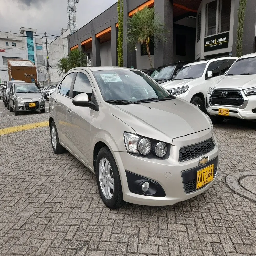

In [3]:
# test load image
image_files = glob.glob(images_folder + '/*/*.png')
image = np.random.choice(image_files)

pil_image = tf.keras.preprocessing.image.load_img(image, target_size=(256, 256))
tf_image = tf.keras.preprocessing.image.img_to_array(pil_image)
print(f'Shape of the image: {tf_image.shape}')
pil_image

In [4]:
# create train and validation set
def create_train_validation_set(image_files, validation_split=0.2):
    train_set = []
    validation_set = []
    for image_file in image_files:
        if np.random.rand() < validation_split:
            # copy image to validation folder
            shutil.copy(image_file, image_file.replace('images', 'validation'))
        else:
            # copy image to train folder
            shutil.copy(image_file, image_file.replace('images', 'train'))

# create train and validation for correct and incorrect labels
def create_set_correct_incorrect(image_files, is_train=True):
    if is_train:
        folder = 'train'
    else:
        folder = 'validation'
    for image_file in image_files:
        if 'other' in image_file:
            # copy image to incorrect folder
            shutil.copy(image_file, image_file.replace(folder, folder+'_correct_incorrect').replace('other', 'incorrect'))
        else:
            # copy image to correct folder
            shutil.copy(image_file, image_file.replace(folder, folder+'_correct_incorrect').replace('back', 'correct').replace('front', 'correct'))


In [ ]:
create_train_validation_set(image_files)

In [ ]:
create_set_correct_incorrect(glob.glob('../train' + '/*/*.png'), is_train=True)
create_set_correct_incorrect(glob.glob('../validation' + '/*/*.png'), is_train=False)

In [5]:
train_images_folder = '../train_correct_incorrect'
validation_images_folder = '../validation_correct_incorrect'

In [9]:
# callbacks
class AccReached(tf.keras.callbacks.Callback):
  def __init__(self):
    pass
  def on_epoch_end(self, epoch, logs={}):
    # print(logs)
    if(logs.get('accuracy') > 0.98):
      print("\nReached 95% accuracy so cancelling training!")
      self.model.stop_training = True

early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True, mode='min', verbose=1)

# learning rate
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
  initial_learning_rate=0.001,
  decay_steps=10000,
  decay_rate=0.9
  )

In [3]:
all_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
all_images = all_datagen.flow_from_directory('../images', target_size=(256, 256), batch_size=1, class_mode='binary', shuffle=False)

Found 8083 images belonging to 3 classes.


In [7]:
batch_size = 32
target_size = (256, 256)
classes = ['incorrect', 'correct']

# image generators
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
)
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

# import images
train_images = train_datagen.flow_from_directory(
  train_images_folder,
  target_size=target_size,
  batch_size=batch_size,
  class_mode='binary',
  classes=classes
)
validation_images = validation_datagen.flow_from_directory(
  validation_images_folder,
  target_size=target_size,
  batch_size=batch_size,
  shuffle=False,
  class_mode='binary',
  classes=classes
)
labels = list(train_images.class_indices.keys())

Found 6436 images belonging to 2 classes.
Found 1643 images belonging to 2 classes.


In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(256, 256, 3)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1014, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [11]:
model.compile(
  loss='binary_crossentropy',
  optimizer=tf.optimizers.SGD(learning_rate=lr_schedule),
  metrics=['accuracy'],
)

In [12]:
history = model.fit(
  train_images,
  steps_per_epoch=6436 // batch_size,
  epochs=150,
  verbose=1,
  callbacks=[AccReached(), early_stop],
  validation_data=validation_images,
)

Epoch 1/150


2022-11-11 17:57:41.466849: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-11 17:57:41.686537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


201/201 [==============================] - ETA: 0s - loss: 0.6584 - accuracy: 0.6432

2022-11-11 17:58:42.324645: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


201/201 [==============================] - 68s 325ms/step - loss: 0.6584 - accuracy: 0.6432 - val_loss: 0.5798 - val_accuracy: 0.7529
Epoch 2/150
201/201 [==============================] - 65s 320ms/step - loss: 0.5517 - accuracy: 0.7384 - val_loss: 0.4661 - val_accuracy: 0.7730
Epoch 3/150
201/201 [==============================] - 65s 321ms/step - loss: 0.5016 - accuracy: 0.7528 - val_loss: 0.4391 - val_accuracy: 0.7845
Epoch 4/150
201/201 [==============================] - 64s 319ms/step - loss: 0.4940 - accuracy: 0.7620 - val_loss: 0.5402 - val_accuracy: 0.7383
Epoch 5/150
201/201 [==============================] - 65s 321ms/step - loss: 0.4799 - accuracy: 0.7670 - val_loss: 0.4625 - val_accuracy: 0.7730
Epoch 6/150
201/201 [==============================] - 65s 321ms/step - loss: 0.4715 - accuracy: 0.7705 - val_loss: 0.4599 - val_accuracy: 0.7785
Epoch 7/150
201/201 [==============================] - 65s 322ms/step - loss: 0.4610 - accuracy: 0.7817 - val_loss: 0.4025 - val_accurac

In [ ]:
# save the model
model.save('labeling_model_ic.h5')

In [13]:
validations_labels = validation_images.classes
predictions = model.predict(validation_images).reshape(-1)

 1/52 [..............................] - ETA: 18s

2022-11-11 19:05:13.886239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


52/52 [==============================] - 6s 105ms/step


In [14]:
print(train_images.class_indices)

{'incorrect': 0, 'correct': 1}


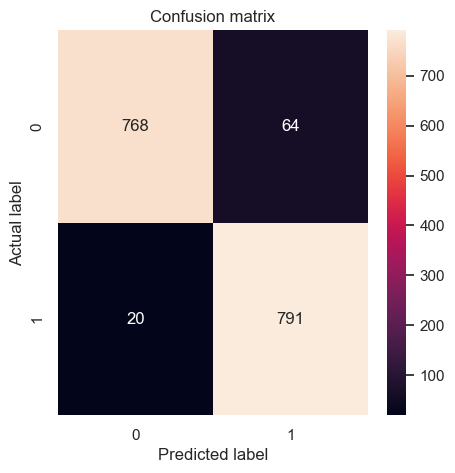

In [15]:
cm = confusion_matrix(validations_labels, predictions > 0.5)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

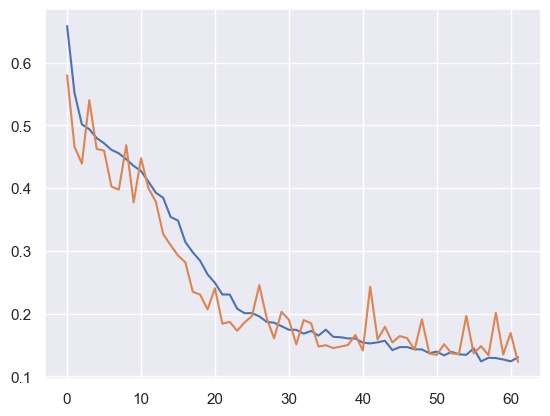

In [16]:
sns.lineplot(np.array(history.history['loss']))
sns.lineplot(np.array(history.history['val_loss']))
plt.show()

In [17]:
cls_a = predictions > 0.5 # only get predictions for class a

In [33]:
def get_image_array(image_path):
    image = tf.keras.preprocessing.image.load_img('../train_correct_incorrect/' + image_path, target_size=(256, 256))
    image = tf.keras.preprocessing.image.img_to_array(image)
    return image

# images_a = np.array(list(map(get_image_array, validation_images.filenames)))[cls_a]

In [19]:
prediction_a = predictions[cls_a]  # get the probs predictions from model
true_a = validations_labels[cls_a]  # get the true values for predictions
errors_a = np.where(np.ones(prediction_a.shape) != true_a, True, False) # get the errors

In [20]:
print(errors_a.shape)
print(images_a.shape)

(855,)
(855, 256, 256, 3)


(64, 1)
(791, 1)


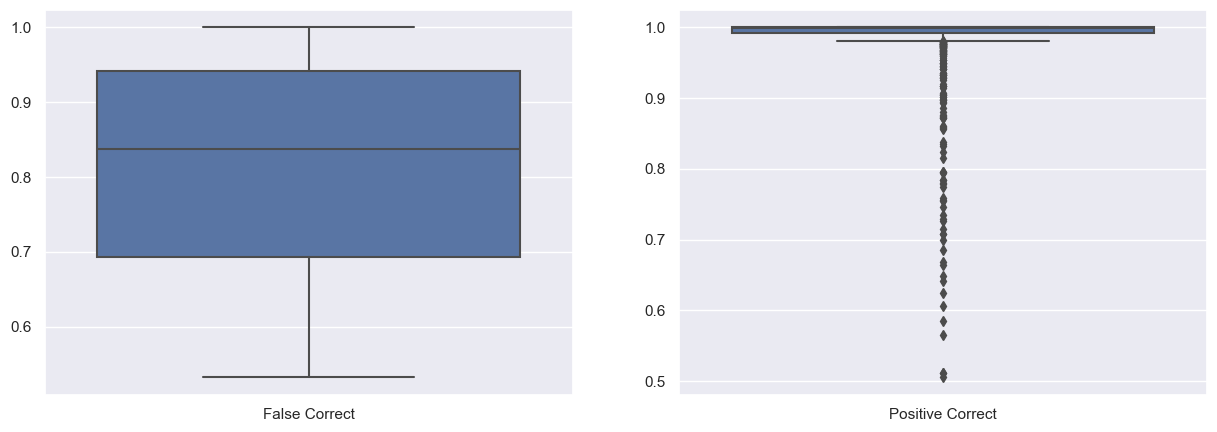

In [21]:
error_df = pd.DataFrame(prediction_a[errors_a], columns=['False Correct'])
correct_df = pd.DataFrame(prediction_a[~errors_a], columns=['Positive Correct'])
print(error_df.shape)
print(correct_df.shape)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(data=error_df, orient='v', ax=ax[0])
sns.boxplot(data=correct_df, orient='v', ax=ax[1])
plt.show()

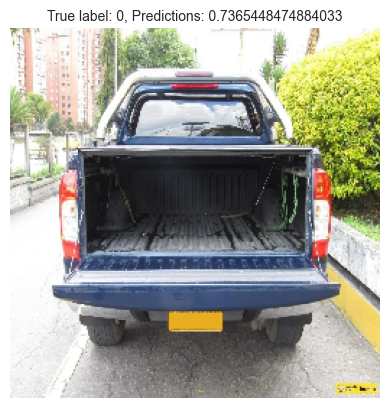

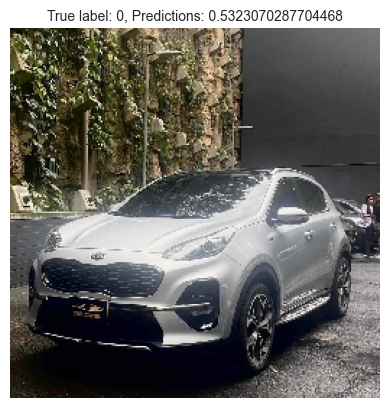

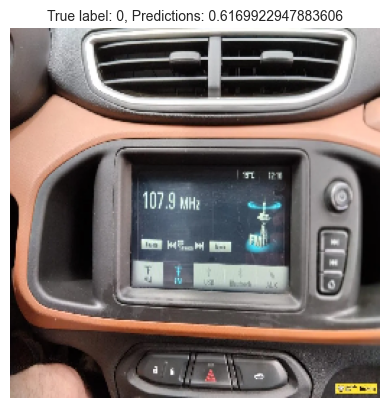

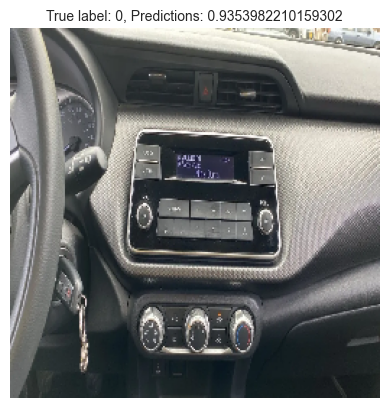

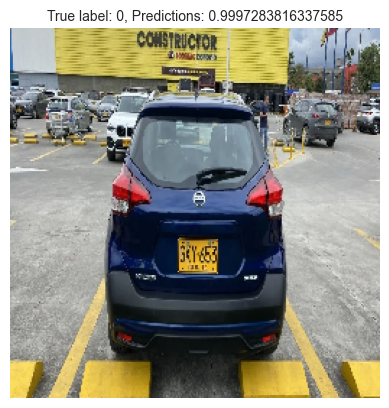

In [22]:
for i in range(5):
  error_image = tf.keras.utils.array_to_img(images_a[errors_a][i])
  fig = plt.figure()
  plt.imshow(error_image)
  plt.axis('off')
  plt.title(f'True label: {true_a[errors_a][i]}, Predictions: {prediction_a[errors_a][i]}', fontsize=10)
plt.show()

In [36]:
def plot_precision_recall(predictions, labels, class_index):
  precision, recall, thresholds = precision_recall_curve(labels, predictions)
  prt = pd.DataFrame({'precision': precision[:-1], 'recall': recall[:-1]}, index=thresholds)
  
  fig, ax = plt.subplots(1, 2, figsize=(15, 5))

  sns.lineplot(data=prt, ax=ax[0])
  ax[0].set_ylabel('Precision - Recall')
  ax[0].set_xlabel('Threshold')
  ax[0].set_title(f'Precision - Recall for {class_index}')

  sns.lineplot(x='precision', y='recall', data=prt, ax=ax[1])
  ax[1].set_ylabel('Recall')
  ax[1].set_xlabel('Precision')
  ax[1].set_title(f'Precision vs Recall for {class_index}')
  plt.show()

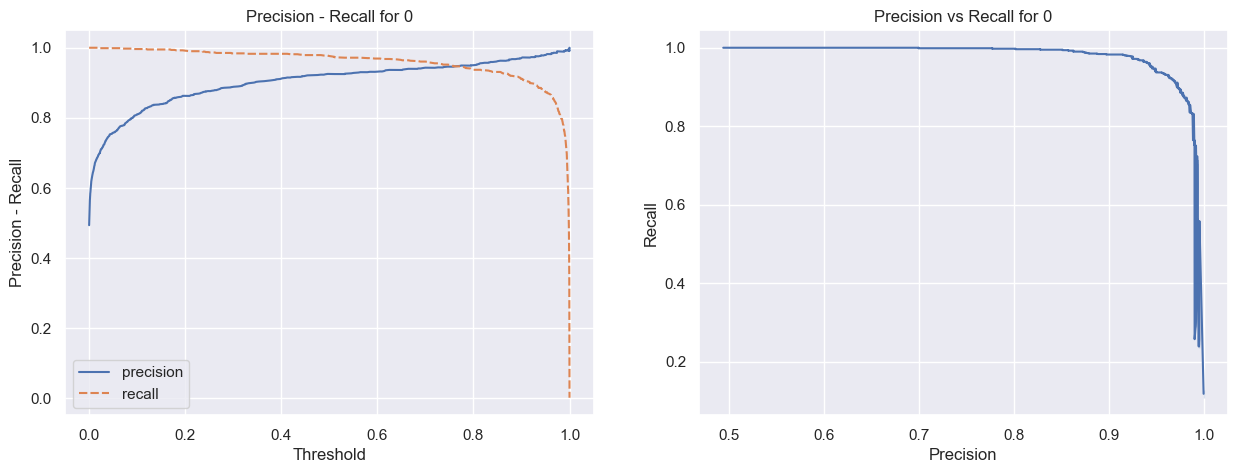

In [37]:
plot_precision_recall(predictions, validations_labels, 0)

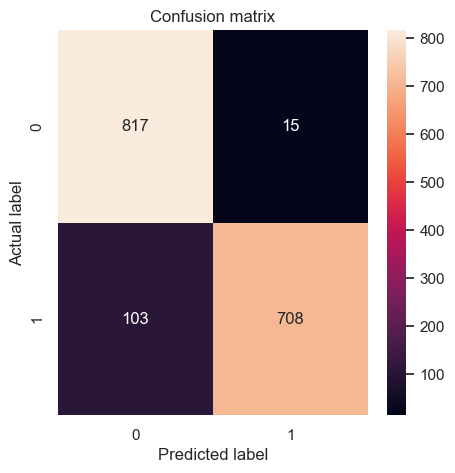

In [26]:
new_label_predictions = np.zeros(predictions.shape)
thresholld = 0.95
for idx, row in enumerate(predictions):
  new_label_predictions[idx] = 1 if row > thresholld else 0

cm = confusion_matrix(validations_labels, new_label_predictions)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
labels